<a href="https://colab.research.google.com/github/NotAndex/Demo/blob/main/time_series_feature_engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0

# 1 Setup


In [44]:
!pip install yfinance
import yfinance as yf

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import datetime

from tensorflow.keras.utils import to_categorical

# 2 Data

In [34]:
today = datetime.date.today()
start_date = today - datetime.timedelta(days=365)
symbol = 'BTC-USD'

cc_data = yf.download(symbol, start=start_date, end=today)
cc_data.reset_index(inplace=True,col_fill=('Date'))

[*********************100%***********************]  1 of 1 completed


#3 Feature engineering examples

## 3.1 Date dependent features

In [35]:
cc_data['year'] = cc_data['Date'].dt.year 
cc_data['quarter'] = cc_data['Date'].dt.quarter 
cc_data['month'] = cc_data['Date'].dt.month 
cc_data['week'] = cc_data['Date'].dt.isocalendar().week 
cc_data['day'] = cc_data['Date'].dt.day
cc_data['wday'] = cc_data['Date'].dt.dayofweek

cc_data.loc[0:5,:]

,Date,Open,High,Low,Close,Adj Close,Volume,year,quarter,month,week,day,wday
0,2020-06-03,9533.760742,9682.859375,9471.846680,9656.717773,9656.717773,25007459262,2020,2,6,23,3,2
1,2020-06-04,9655.854492,9887.610352,9525.247070,9800.636719,9800.636719,25921805072,2020,2,6,23,4,3
2,2020-06-05,9800.215820,9869.237305,9663.216797,9665.533203,9665.533203,23509628646,2020,2,6,23,5,4
3,2020-06-06,9664.904297,9773.431641,9591.024414,9653.679688,9653.679688,20438419222,2020,2,6,23,6,5
4,2020-06-07,9653.002930,9768.498047,9458.150391,9758.852539,9758.852539,25015250846,2020,2,6,23,7,6
5,2020-06-08,9760.063477,9782.306641,9675.885742,9771.489258,9771.489258,21486346312,2020,2,6,24,8,0


Since there is no predetermined (ordinal) relationship in the relevance of days or months we can encode its representation nominal via One-Hot encoding. Forcing an ordinal relationship with ordinal encoding and allowing the model to assume a natural ordering between categories may result in poor performance or unexpected results (predictions halfway between categories).

In [36]:
monthCat = pd.DataFrame(to_categorical(cc_data.loc[:,['month']]))
cc_data = pd.concat([cc_data,monthCat.loc[:,1:]],axis=1)

dayCat = pd.DataFrame(to_categorical(cc_data.loc[:,['wday']]),
                          columns=["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"])
cc_data = pd.concat([cc_data,dayCat],axis=1)

In [37]:
cc_data.loc[0:6,["wday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]]

,wday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,3,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,4,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,5,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,6,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0


# 3.2 Technical features (Indicators **$f_{x}$**)

### 3.2.1 Highs and Lows for given time horizon

In [38]:
week_low = cc_data.groupby(pd.Grouper(key='Date', freq='W'))['Close'].idxmin()
cc_data['weekly_low'] = 0
cc_data.loc[week_low,['weekly_low']] = 1

week_high = cc_data.groupby(pd.Grouper(key='Date', freq='W'))['Close'].idxmax()
cc_data['weekly_high'] = 0
cc_data.loc[week_high,['weekly_high']] = 1

In [39]:
cc_data.loc[0:6,['Close','wday','weekly_low','weekly_high']]

,Close,wday,weekly_low,weekly_high
0,9656.717773,2,0,0
1,9800.636719,3,0,1
2,9665.533203,4,0,0
3,9653.679688,5,1,0
4,9758.852539,6,0,0
5,9771.489258,0,0,0
6,9795.700195,1,0,0


### 3.2.2 

In [40]:
cc_data['up_trend_indicator'] = 0
cc_data['down_trend_indicator'] = 0
cc_data['trend_duration_indicator'] = 0
cc_data['daily_change'] = 0
count = 0
for i in range(len(cc_data)):
    if i == 0:
        #first entry of the time series
        cc_data.loc[i,'up_trend_indicator'] = 1
        cc_data.loc[i,'down_trend_indicator'] = 1
        cc_data.loc[i,'trend_duration_indicator'] = 0
        cc_data.loc[i,'daily_change'] = 0   
    else:

        if (i > 0) and (cc_data.loc[i,'Close'] > cc_data.loc[i-1,'Close']):
            cc_data.loc[i,'up_trend_indicator'] = 1
            cc_data.loc[i,'down_trend_indicator'] = 0
            cc_data.loc[i,'daily_change'] = cc_data.loc[i,'Close'] - cc_data.loc[i-1,'Close']
            if (cc_data.loc[i-1,'up_trend_indicator'] == 1):
                count += 1
                cc_data.loc[i,'trend_duration_indicator'] = count
            else:
                count = 0

        if(i > 0) and (cc_data.loc[i,'Close'] < cc_data.loc[i-1,'Close']):
            cc_data.loc[i,'up_trend_indicator'] = 0
            cc_data.loc[i,'down_trend_indicator'] = 1
            cc_data.loc[i,'daily_change'] = cc_data.loc[i,'Close'] - cc_data.loc[i-1,'Close']
            if (cc_data.loc[i-1,'up_trend_indicator'] == 0):
                count += 1
                cc_data.loc[i,'trend_duration_indicator'] = count
            else:
                count = 0

In [41]:
cc_data.loc[0:6,['Date','Close','daily_change','up_trend_indicator','down_trend_indicator','trend_duration_indicator']]

,Date,Close,daily_change,up_trend_indicator,down_trend_indicator,trend_duration_indicator
0,2020-06-03,9656.717773,0.000000,1,1,0
1,2020-06-04,9800.636719,143.918945,1,0,1
2,2020-06-05,9665.533203,-135.103516,0,1,0
3,2020-06-06,9653.679688,-11.853516,0,1,1
4,2020-06-07,9758.852539,105.172852,1,0,0
5,2020-06-08,9771.489258,12.636719,1,0,1
6,2020-06-09,9795.700195,24.210938,1,0,2


### 3.2.3

In [42]:
cc_data['SMA_7'] = cc_data['Close'].rolling(window=7, min_periods=1).mean()
cc_data['SMA_28'] = cc_data['Close'].rolling(window=28, min_periods=1).mean()

cc_data['EMA_100'] = cc_data['Close'].ewm(span=100, adjust=False).mean()
cc_data['EMA_200'] = cc_data['Close'].ewm(span=200, adjust=False).mean()

# 3.3 External Features
e.g Sentinment

# 4 Plots

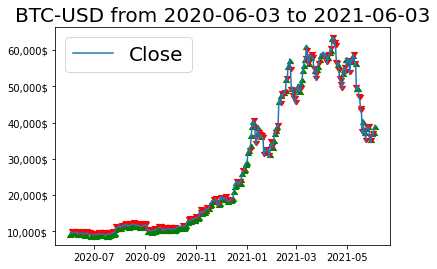

In [48]:
fig0, ax = plt.subplots()
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}$'))

ax.plot(cc_data.loc[:,'Date'], cc_data.loc[:,'Close'], label = 'Close')
ax.scatter(cc_data.loc[cc_data['up_trend_indicator'] == 1]['Date'],
           cc_data.loc[cc_data['up_trend_indicator'] == 1]['Close'],
           color = "Green",
           marker = 6)
ax.scatter(cc_data.loc[cc_data['up_trend_indicator'] == 0]['Date'],
           cc_data.loc[cc_data['up_trend_indicator'] == 0]['Close'],
           color = "Red" ,
           marker = 7)
ax.set_title((f'{symbol} from {start_date} to {today}'), fontsize = 20)
ax.legend(fontsize=20)